In [8]:
%%html
<style>
div.input {
    display:none;
}
</style>

# Análise exploratória de dados em segmentação do corpo caloso

Nome: William Javier García Herrera

RA: 162642

# Motivação do problema

O corpo caloso (CC) é a maior estrutura de substância branca no cérebro, está localizada sob o córtex cerebral e conecta os dois hemisférios cerebrais, permitindo o intercambio de informação entre eles. Sua forma e tamanho estão associadas com características do sujeito e alterações do corpo caloso apresentam correlação com várias doenças e condições médicas. O estudo do CC é melhor feito em imagens de ressonância magnética (MRI), uma vez que elas fornecem melhor contraste de tecidos moles do que outras tecnologias de imageamento. A segmentação do CC em MRI, permite a extração de características morfológicas e fisiológicas da estrutura, possibilitando avaliação tanto de indivíduos quanto de populações es estudos clínicos e de pesquisa.

Para estudo do CC usam-se duas modalidades de MRI: imagens ponderadas em T1 e imagens ponderadas em difusão. As imagens baseadas em difusão apresentam baixa resolução, definição e contraste, o que torna a segmentação um processo desafiador. Porém, a segmentação em difusão é ainda desejável dado que este tipo de imagens oferece informação adicional, não presente em outras modalidades, e permite estudar a microestrutura das fibras neuronais usando um modelo de difusão da água.

A avaliação dos métodos de segmentação, em qualquer modalidade, é feita usando um padrão com o qual comparar o resultado e uma métrica que permite a avaliação quantitativa. Em difusão é comunmente usado um padrão-prata, que é uma boa aproximação para um padrão ideal. Nesta tarefa, iremos explorar uma matriz que contém resultados de avaliação de 3 métodos de segmentação (Watershed, ROQS e Método baseado em píxel) sobre a fatia central do CC (imagem 2D) para 145 sujeitos, usando 3 padrões-prata (Registrado, Semi-automático e STAPLE) e 6 métricas (Sensibilidade, Especificidade, Dice, Distância Hausdorff, área e RMSE). As 5 primeiras métricas, apresentadas na tabela a seguir, são frequentemente usadas na literatura e estão bem estabelecidas:

|       Métrica       |                                Descrição                                |Faixa  | Valor ideal |
|---------------------|-------------------------------------------------------------------------|-------|-------------|
|    Sensibilidade    | Fração de píxels corretamente classificados como objeto |  [0-1]  |      1      |
|    Especificidade   | Fração de píxels corretamente classificados como fundo  |  [0-1]  |      1      |
|         Dice        |       Grau de sobreposição das duas estruturas          |  [0-1]  |      1      |
|        Área         |         Relação de área entre segmentação e padrão         | [0-17920] |      1      |
| Distância Hausdorff |       Distância entre os contornos das estruturas        | [0-266) |      0      |

Já a métrica RMSE foi proposta como parte de meu projeto de mestrado e portanto não tem sido caracterizada. RMSE é uma métrica que permite avaliar segmentações usando como base um descriptor de forma, e tem as seguintes características:

|       Métrica       |                                Descrição                                |Faixa  | Valor ideal |
|---------------------|-------------------------------------------------------------------------|-------|-------------|
|         RMSE        | Erro entre os perfis de curvatura associados às formas das estruturas |  [0-1]  |      0      |


Pretende-se, nesta tarefa, responder as seguintes questões usando a análise exploratória de dados:

### Quais são as características da métrica RMSE? Esta correlacionada com alguma outra métrica? Quais são as zonas de operação da métrica? É discriminativa para a avaliar segmentações?

## Exploração dos dados
Primeiro é carregada a matriz de informação: 6 métricas (Sensibilidade, especificidade, Dice, distância Hausdorff, área e RMSE), 145 sujeitos e 9 combinações segmentação vs padrão (Watershed vs registrada; Watershed vs semi-automática; Wateshed vs STAPLE; ROQS vs registrada; ROQS vs semi-automática; ROQS vs STAPLE; Baseado em píxel vs registrada; Baseado em píxel vs semi-automática; Baseado em píxel vs STAPLE)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import csv
import scipy.stats as stats
%matplotlib inline

matrix = np.load('eval_silver_standard.npy')
print "Shape da matriz: ", matrix.shape

Shape da matriz:  (6, 145, 9)


## Boxplot

Uma primeira aproximação, na exploração da informação, é o uso de boxplot para tentar entender a distribuição dos dados. A melhor maneira de ser feito é usando um grupo de boxplot por cada métrica, agrupando os três métodos de segmentação por cada padrão. Os dados possuem um número considerável de outliers. Dado que todos os sujeitos têm um CC possível de ser segmentado na fatia escolhida para a avaliação, os outliers correspondem a métodos que segmentaram errado ou/e padrões que foram mal construídos.

Ainda que visualizar os outliers é importante, porém devido à escala, os outliers podem dificultar a visualização dos boxplot em si. Por isso, cada grupo de boxplot é apresentado com outliers (lado esquerdo) e sem outliers (lado direito).

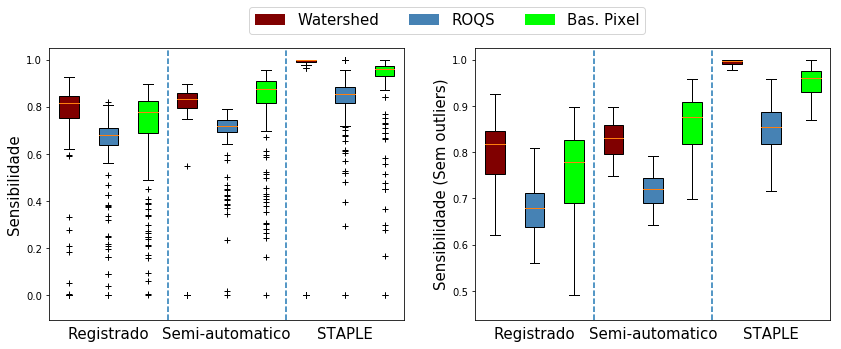

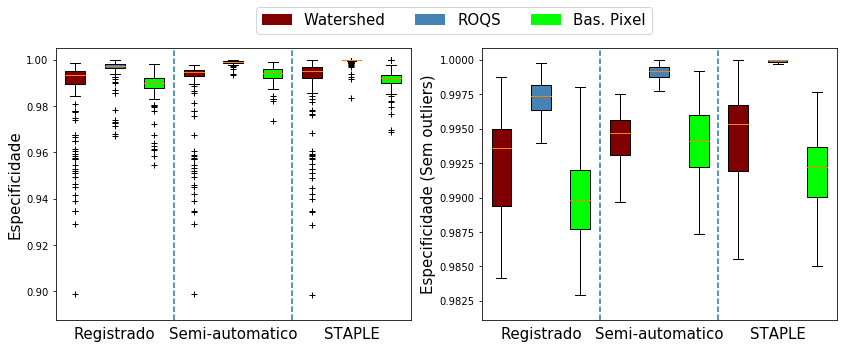

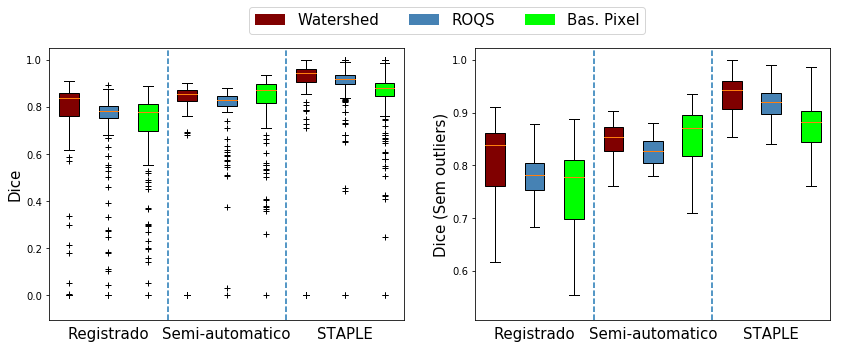

In [10]:
labels = ["", "Registrado", "", "", "Semi-automatico", "", "", "STAPLE", ""]
cores = ["maroon","steelblue","lime","maroon","steelblue","lime","maroon","steelblue","lime"]
metrica = ["Sensibilidade","Especificidade","Dice","Area","Distancia Hausdorff","RMSE"]
metrica_aj = ["Sensibilidade (Sem outliers)","Especificidade (Sem outliers)","Dice (Sem outliers)"
              ,"Area (Sem outliers)","Distancia Hausdorff (Sem outliers)","RMSE (Sem outliers)"]
seg_pad = ["Wat-Reg","ROQS-Reg","Pix-Reg","Wat-Sem","ROQS-Sem","Pix-Sem","Wat-STA","ROQS-STA","Pix-STA"]
#meanpointprops = dict(marker='^',markeredgecolor='black',markerfacecolor='orange')

for metric in xrange(matrix.shape[0]/2):
    ##### Boxplot com outliers#####
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(14, 5, forward=True)
    #plot = ax1.boxplot(matrix[metric,:,:],showmeans=True,meanprops=meanpointprops,labels=labels,patch_artist=True)
    plot = ax1.boxplot(matrix[metric,:,:],0,'+',labels=labels,patch_artist=True)
    for patch, color in zip(plot['boxes'], cores):
        patch.set_facecolor(color)
    ax1.set_ylabel('%s'%metrica[metric],fontsize=15)
    ax1.tick_params(axis='x',labelsize=15)
    y_val_min, y_val_max = ax1.get_ylim()
    val_ajs = (y_val_max - y_val_min)*0.05
    ax1.set_ylim(y_val_min-val_ajs, y_val_max)
    ax1.axvline(x=[3.5],linestyle='--')
    ax1.axvline(x=[6.5],linestyle='--')
    ax1.xaxis.set_ticks_position('none')
    b1 = ax1.bar([0,3,6],[0,0,0],color="maroon",width=0,label="Watershed", align="center")
    b2 = ax1.bar([1,4,7],[0,0,0],color="steelblue",width=0,label="ROQS",align="center")
    b3 = ax1.bar([2,5,8],[0,0,0],color="lime",width=0,label="Bas. Pixel",align="center")
    #ax1.legend(bbox_to_anchor=[0.938, 1.12], ncol=3, labelspacing=2)

    ##### Boxplot sem outliers#####
    plot = ax2.boxplot(matrix[metric,:,:],showfliers=False,labels=labels,patch_artist=True)
    for patch, color in zip(plot['boxes'], cores):
        patch.set_facecolor(color)
    ax2.set_ylabel('%s'%metrica_aj[metric],fontsize=15)
    ax2.tick_params(axis='x',labelsize=15)
    y_val_min, y_val_max = ax2.get_ylim()
    val_ajs = (y_val_max - y_val_min)*0.05
    ax2.set_ylim(y_val_min-val_ajs, y_val_max)
    ax2.axvline(x=[3.5],linestyle='--')
    ax2.axvline(x=[6.5],linestyle='--')
    ax2.xaxis.set_ticks_position('none')
    b1 = ax2.bar([0,3,6],[0,0,0],color="maroon",width=0,label="Watershed", align="center")
    b2 = ax2.bar([1,4,7],[0,0,0],color="steelblue",width=0,label="ROQS",align="center")
    b3 = ax2.bar([2,5,8],[0,0,0],color="lime",width=0,label="Bas. Pixel",align="center")
    ax2.legend(bbox_to_anchor=[0.5, 1.18], ncol=3,labelspacing=2,fontsize=15)

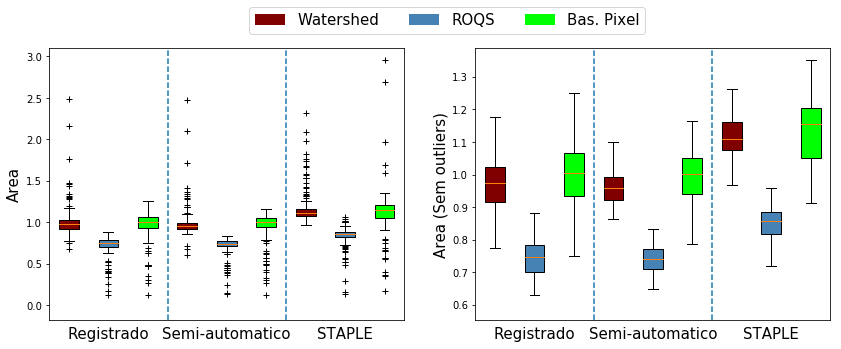

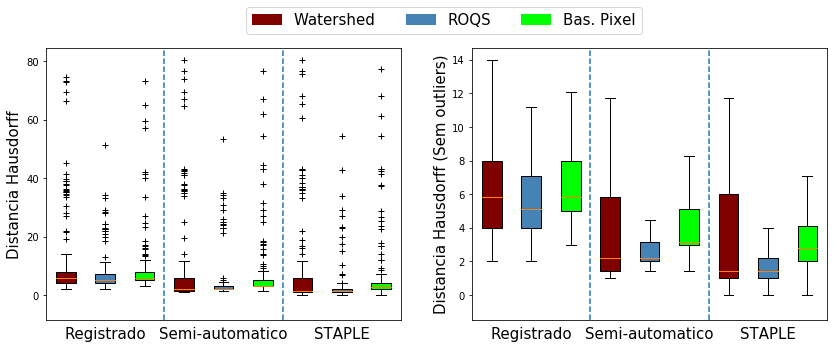

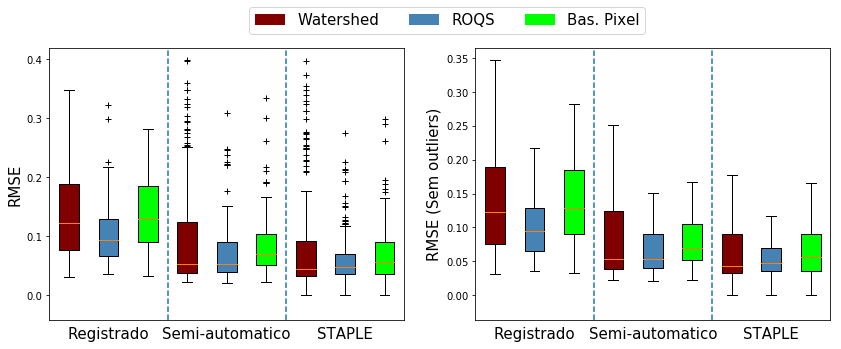

In [11]:
for metric in xrange(matrix.shape[0]/2,matrix.shape[0]):
    ##### Boxplot com outliers#####
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(14, 5, forward=True)
    #plot = ax1.boxplot(matrix[metric,:,:],showmeans=True,meanprops=meanpointprops,labels=labels,patch_artist=True)
    plot = ax1.boxplot(matrix[metric,:,:],0,'+',labels=labels,patch_artist=True)
    for patch, color in zip(plot['boxes'], cores):
        patch.set_facecolor(color)
    ax1.set_ylabel('%s'%metrica[metric],fontsize=15)
    ax1.tick_params(axis='x',labelsize=15)
    y_val_min, y_val_max = ax1.get_ylim()
    val_ajs = (y_val_max - y_val_min)*0.05
    ax1.set_ylim(y_val_min-val_ajs, y_val_max)
    ax1.axvline(x=[3.5],linestyle='--')
    ax1.axvline(x=[6.5],linestyle='--')
    ax1.xaxis.set_ticks_position('none')
    b1 = ax1.bar([0,3,6],[0,0,0],color="maroon",width=0,label="Watershed", align="center")
    b2 = ax1.bar([1,4,7],[0,0,0],color="steelblue",width=0,label="ROQS",align="center")
    b3 = ax1.bar([2,5,8],[0,0,0],color="lime",width=0,label="Bas. Pixel",align="center")
    #ax1.legend(bbox_to_anchor=[0.938, 1.12], ncol=3, labelspacing=2)

    ##### Boxplot sem outliers#####
    plot = ax2.boxplot(matrix[metric,:,:],showfliers=False,labels=labels,patch_artist=True)
    for patch, color in zip(plot['boxes'], cores):
        patch.set_facecolor(color)
    ax2.set_ylabel('%s'%metrica_aj[metric],fontsize=15)
    ax2.tick_params(axis='x',labelsize=15)
    y_val_min, y_val_max = ax2.get_ylim()
    val_ajs = (y_val_max - y_val_min)*0.05
    ax2.set_ylim(y_val_min-val_ajs, y_val_max)
    ax2.axvline(x=[3.5],linestyle='--')
    ax2.axvline(x=[6.5],linestyle='--')
    ax2.xaxis.set_ticks_position('none')
    b1 = ax2.bar([0,3,6],[0,0,0],color="maroon",width=0,label="Watershed", align="center")
    b2 = ax2.bar([1,4,7],[0,0,0],color="steelblue",width=0,label="ROQS",align="center")
    b3 = ax2.bar([2,5,8],[0,0,0],color="lime",width=0,label="Bas. Pixel",align="center")
    ax2.legend(bbox_to_anchor=[0.5, 1.18],ncol=3,labelspacing=2,fontsize=15)

A superioridade de um método de segmentação sobre outro depende do padrão usado e da métrica utilizada na avaliação. Dado que não se tem um padrão-ouro absoluto e uma métrica que leve em consideração todos os aspectos da segmentação, é impossível concluir qual segmentação é superior. Nesse sentido, é notável que a escolha da métrica e o padrão determinam esta superioridade e esta escolha depende do objetivo da avaliação.

Podem-se fazer as seguintes observações:
- O STAPLE como padrão costuma ter o melhor desempenho para qualquer segmentação com a maioria das métricas, exceptuando área e especificidade.
- RMSE parece estar correlacionada com a distância Hausdorff dado o comportamento similar dos boxplot entre padrões, e de cada segmentação ao interior de um padrão dado. Esta observação tem suporte no fato da distância Hausdorff ser uma métrica de distância ponto a ponto da borda que implicitamente mede a forma da estrutura como faz RMSE. RMSE, por outro lado, mede a distância ponto a ponto do perfil de curvatura, uma forma de capturar a forma da estrutura.
- No gráfico de RMSE, o ROQS é o método que maior consistência tem quando avaliado com um padrão. Esta afirmação está baseada no fato que este método tem menor variação (distância inter-quartis) do que os outros métodos para a maioria dos casos.
- O poder de discriminação, entendido como a capacidade da métrica de diferenciar uma 

## Matriz de correlação

A correlação entre métricas pode ajudar a caracterizar RMSE em relação às outras, usando o conhecimento a priori que temos sobre elas. A matrix a seguir representa a correlação, usando o valor absoluto do coeficiente de Pearson, que tem RMSE com as outras métricas para cada possível combinação de padrão e segmentação. As métricas forma normalizadas entre 0 e 1. O coeficiente de Pearson é dado em valor absoluto já que sensibilidade, especificidade e Dice tendem a aumentar conforme a qualidade da segmentação, entanto que a distância Hausdorff e RMSE tendem a diminuir; área tende a variar em torno a 1. Em geral, um valor absoluto de correlação de Pearson maior que 0.7 indica uma correlação forte.

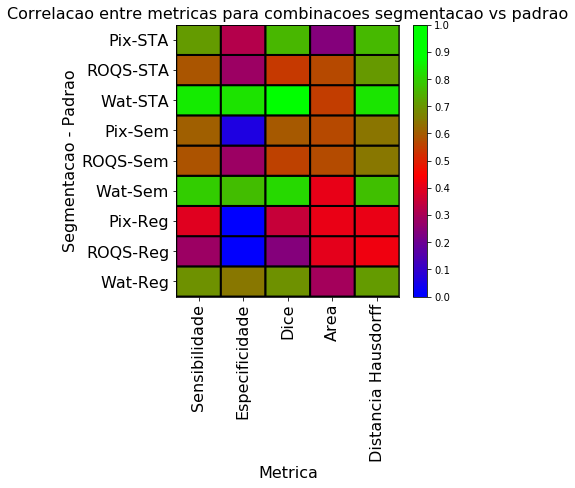

In [12]:
## Normalização por métrica
for metric in xrange(matrix.shape[0]):
    matrix[metric] = matrix[metric]/np.amax(matrix[metric])

rel_corr = np.zeros((9,6))
for seg in xrange(matrix.shape[2]):
    for metric in xrange(matrix.shape[0]):
        rel_corr[seg,metric] = np.abs(stats.pearsonr(matrix[5,:,seg],matrix[metric,:,seg])[0])
rel_corr = rel_corr[:,:-1]
        
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5, 5, forward=True)
fig1 = ax.pcolor(rel_corr,edgecolors='k',cmap='brg',linewidths=2,clim=(0,1))

ax.set_xticks(np.arange(0.5,5,1))
ax.set_yticks(np.arange(0.5,9,1))
ax.set_xticklabels(metrica[:-1],rotation='vertical',fontsize=16)
ax.set_yticklabels(seg_pad,fontsize=16)
plt.title('Correlacao entre metricas para combinacoes segmentacao vs padrao',fontsize=16)
plt.ylabel('Segmentacao - Padrao',fontsize=16)
plt.xlabel('Metrica',fontsize=16)
fig.colorbar(fig1,ticks=np.arange(0,1.1,0.1),boundaries=np.linspace(0,1,100))

A matriz de correlação mostra, em geral, uma correlação alta entre RMSE e a distância de Hausdorff e uma correlação fraca com área. No caso de sensibilidade, Dice e especificidade, tem-se uma correlação variável com RMSE, sendo moderada para as duas primeiras e baixa para a última. Dice e sensibilidade parecem ser métricas correlacionadas entre elas.

## Gráficos de dispersão

Será usado gráfico de dispersão já que este tipo de visualização facilita explorar em detalhe os dados e permite enxergar correlação entre variáveis. A seguir será apresentada uma análise em detalhe dos valores de RMSE em comparação com alguma das métricas da literatura que pareça mais interessante segundo as observações até agora formuladas. Analisar visualmente a RMSE junto com todas as métricas faria difícil a análise. Por isso, escolheremos só o Dice para ser comparado com a RMSE já que é a métrica mais versátil e usada na literatura. Novamente, o RMSE é normalizado para que opere na mesma faixa que o Dice.

Dado que temos várias combinações possíveis de padrão vs segmentação, será usado um grid de gráficos, onde cada celda é o resultado de avaliação, usando RMSE, Dice e distância Hausdorff, entre um padrão (linhas) e uma segmentação (colunas) para os 151 sujeitos. Para cada subplot, iremos ordenar de forma crescente os sujeitos pelo Dice com o intuito de facilitar a descoberta de padrões e usar o Dice como base de análise.

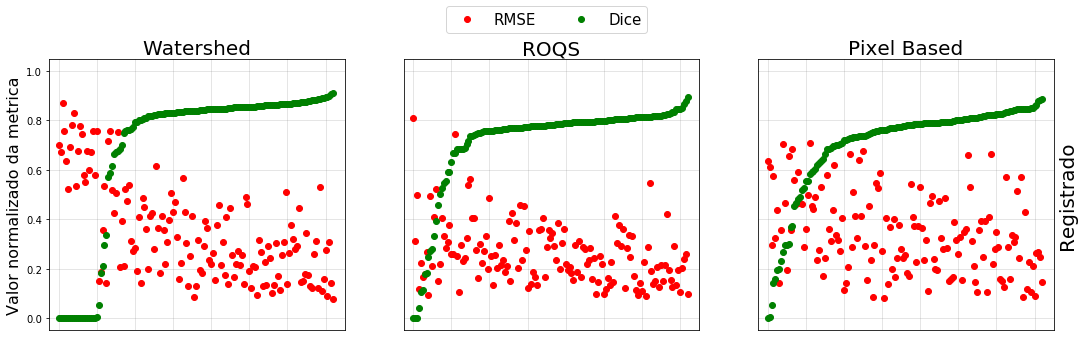

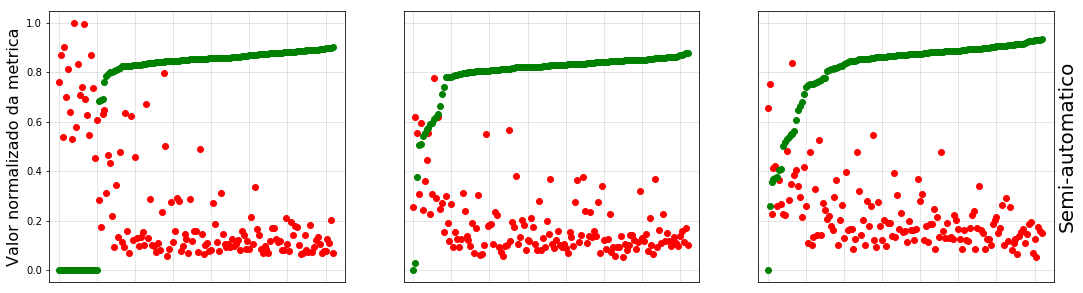

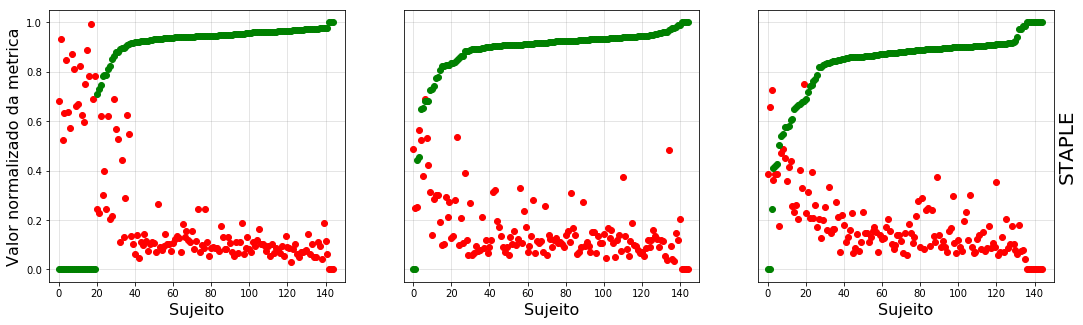

In [13]:
seg_ = ["Watershed","ROQS","Pixel Based"]
pad_ = ["Registrado","Semi-automatico","STAPLE"]

for seg in xrange(matrix.shape[2]/3):
    #### Ordenação dos dados pelo Dice
    order_array1 = np.argsort(matrix[2,:,seg*3])
    order_array2 = np.argsort(matrix[2,:,seg*3+1])
    order_array3 = np.argsort(matrix[2,:,seg*3+2])
    #### Configurando subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(18, 5, forward=True)
    #### Plotando gráficos de dispersão
    plot = ax1.plot(matrix[5,order_array1,seg*3],'ro',label='RMSE')
    plot = ax1.plot(matrix[2,order_array1,seg*3],'go',label='Dice')
    #plot = ax1.plot(matrix[4,order_array1,seg*3],'bo',label='Distancia Hausdorff')
    
    plot = ax2.plot(matrix[5,order_array2,seg*3+1],'ro',label='RMSE')
    plot = ax2.plot(matrix[2,order_array2,seg*3+1],'go',label='Dice')
    #plot = ax2.plot(matrix[4,order_array2,seg*3+1],'bo',label='Distancia Hausdorff')
        
    plot = ax3.plot(matrix[5,order_array3,seg*3+2],'ro',label='RMSE')
    plot = ax3.plot(matrix[2,order_array3,seg*3+2],'go',label='Dice')
    #plot = ax3.plot(matrix[4,order_array3,seg*3+2],'bo',label='Distancia Hausdorff')
    #### Configurando axis
    ax1.grid(color='gray', linestyle='-',linewidth=1, alpha=0.2)
    ax2.grid(color='gray', linestyle='-',linewidth=1, alpha=0.2)
    ax3.grid(color='gray', linestyle='-',linewidth=1, alpha=0.2)
    ax1.axis((-5,150,-0.05,1.05))
    if seg != 2:
        ax1.tick_params(bottom='off',labelbottom='off')
        ax2.tick_params(bottom='off',labelbottom='off')
        ax3.tick_params(bottom='off',labelbottom='off')
    if seg == 2:
        ax1.set_xlabel('Sujeito',fontsize=16)
        ax2.set_xlabel('Sujeito',fontsize=16)
        ax3.set_xlabel('Sujeito',fontsize=16)
    ax1.set_ylabel('Valor normalizado da metrica',fontsize=16)
    
    ax2.axis((-5,150,-0.05,1.05))
    ax2.tick_params(left='off',labelleft='off')
    
    ax3.axis((-5,150,-0.05,1.05))
    ax3.tick_params(left='off',labelleft='off')
    
    ax3.set_ylabel(pad_[seg],fontsize=20)
    ax3.yaxis.set_label_position("right")
    
    if seg == 0:
        ax3.legend(bbox_to_anchor=[-0.35, 1.22], ncol=3,labelspacing=2,fontsize=15)
        ax1.set_xlabel(seg_[0],fontsize=20)
        ax1.xaxis.set_label_position("top")
        ax2.set_xlabel(seg_[1],fontsize=20)
        ax2.xaxis.set_label_position("top")
        ax3.set_xlabel(seg_[2],fontsize=20)
        ax3.xaxis.set_label_position("top")

## Conclusões

A distribuição desordenada dos pontos da RMSE difere da distribuição uniforme do Dice para cada gráfico. As duas métricas levam em consideração aspectos diferentes da estrutura o que indica que a RMSE pode ser usada como métrica complementaria do Dice. Em  alguns casos, segmentações com Dice similares podem ter RMSE muito diferentes indicando boa sobreposição com o padrão, mas diferença na forma das estruturas.

As zonas de operação do Dice permitem obter informação sobre a faixa de operação da nossa métrica:

- Nos gráficos da coluna da segmentação baseada em Watershed, o Dice para os primeiros 20 sujeitos é igual a zero. Estes casos tem uma RMSE normalizada alta, maior a 0.5.
- Por outro lado, zonas onde o Dice é maior a 0.8, a RMSE está abaixo de 0.5. Esta zona, nos gráficos, normalmente corresponde a segmentações que coincidem relativamente bem com o respetivo padrão.

$RMSE=0.5$,no caso normalizado,  pode ser considerado um limiar entre valores aceitáveis ($RMSE<0.5$) e valores ruins de RMSE ($RMSE>0.5$). Este valor é equivalente a 0.2 para RMSE sem normalizar.

Ainda que, na avaliação, Dice e RMSE levem em conta aspectos diferentes dos pares padrão-segmentação, a tendencia geral de ambas métricas esta inversamente relacionadas. Olhando para os padrões, pode-se notar que as avaliações usando o STAPLE têm melhores valores das duas métricas do que os outros padrões: os pontos da RMSE estão mais aglomerados na parte inferior, próxima de zero, entanto que os pontos do Dice estão mais aglomerados na parte superior, próxima de um. As duas métricas concordam em que a avaliação com STAPLE dá melhores resultados para todas as segmentações.